# Tissue Classification using Neural Networks
In this lab we will explore the use of texture in images and traditional machine learning approaches such as clustering. The dataset we will be using is available here: http://dx.doi.org/10.5281/zenodo.53169. 

![alt text](https://www.researchgate.net/profile/Jakob_Kather/publication/303998214/figure/fig7/AS:391073710002224@1470250646407/Representative-images-from-our-dataset-Here-the-first-10-images-of-every-tissue-class.png)

The above figure shows the 8 different classes of tissue we will be trying to identify. 

In [0]:
# Imports
from __future__ import print_function
import os
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

## Step 1
* Load the data (done for you)
 * The "data" variable stores 5000 images of shape 150x150. This means data has shape (5000, 150, 150). These images are loaded here as grayscale.
 * The "labels" variable stores 5000 labels (0-7). This means "labels" has shape (5000,)
* Split data into training and testing subsets (left up to you)
 * Check out the sklearn function train_test_split from sklearn.model_selection

In [10]:
! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git

# Build the path to the data folder. No need to change directories
# There are a total of 6 files you will have to load
data_dir = os.path.join( os.getcwd(), 'Week3_public', 'data', 'crc')

fatal: destination path 'Week3_public' already exists and is not an empty directory.


In [11]:
# Load data and split into training, testing sets
y = np.load(os.path.join(data_dir, 'rgb01.npz'))
labels = y['labels']
data = y['rgb_data']
data = data[:,:,:,]
label_str = y['label_str']
label_str = label_str.tolist() # this is to convert label_str back to a dictionary
y = []

print(data.shape)
for ii in range(2,6):
    filename = os.path.join(data_dir, 'rgb0' + str(ii) + '.npz')
    print('loading ', filename)
    y = np.load(filename)
    labels = np.append(labels, y['labels'], axis=0)
    data = np.append(data, y['rgb_data'][:,:,:,], axis=0)
    print(data.shape)
    y = []


print( data.shape )
print( labels.shape )

(1000, 150, 150, 3)
loading  /content/Week3_public/data/crc/rgb02.npz
(2000, 150, 150, 3)
loading  /content/Week3_public/data/crc/rgb03.npz
(3000, 150, 150, 3)
loading  /content/Week3_public/data/crc/rgb04.npz
(4000, 150, 150, 3)
loading  /content/Week3_public/data/crc/rgb05.npz
(5000, 150, 150, 3)
(5000, 150, 150, 3)
(5000,)


In [0]:
num_images, nrows, ncols, nvals = data.shape

X_train, X_test, train_labels, test_labels = train_test_split(data, labels, test_size=.2, random_state=0)
X_train, X_val, train_labels, val_labels = train_test_split(X_train, train_labels, test_size=.2, random_state=0)

X_train = X_train.astype('float64')
X_val = X_val.astype('float64')
X_test = X_test.astype('float64')


train_labels = to_categorical(train_labels, 8)
val_labels = to_categorical(val_labels, 8)
test_labels = to_categorical(test_labels, 8)

## Normalize data
All images should be normalized to the range 0-1 by dividing by 255.

#### Note
* Using the La\*b colorspace : If you convert your images to the La\*b colorspace, the scaling factor will change. Each channel in this colorspace will have a different range and normalization of each space will involve scaling each channel separately. Additionally, the a\* channel can have a negative range. This also needs to be taken into account. 
* Using the HSV/HSI colorspace : Similar considerations apply if you are using the HSV/HSI colorspace. The only difference is that the HSV/HSI colorspace will have all positive values.

In [13]:

# Assuming we are using the RGB colorspace# Assum 
# Normalize all images so that they are 0-1
'''X_train_new = np.zeros((4000,64,64))
X_test_new = np.zeros((1000,64,64))

for i in range(len(X_train)):
  X_train_new[i] = resize(image=X_train[i], output_shape=(64, 64))

for i in range(len(X_test)):
  X_test_new[i] = resize(image=X_test[i], output_shape=(64, 64))
  
X_train = X_train_new
X_test = X_test_new'''
num_images, nrows, ncols, nvals = X_train.shape

X_train = X_train/255
X_test = X_test/255

'''
X_train = X_train.reshape(4000, nrows*ncols)
X_test = X_test.reshape(1000, nrows*ncols)'''

print(X_train.shape, X_test.shape)
num_classes = 8 

(3200, 150, 150, 3) (1000, 150, 150, 3)


## Step 2
At this point, the data has been split into training and testing sets and normalized. We will now design a fully connected neural network for texture classification. 


![alt text](http://adventuresinmachinelearning.com/wp-content/uploads/2017/04/CNN-example-block-diagram.jpg)


( Image from http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/ )

When designing a fully connected network for classification, we have several decisions to make.

**Network Architecuture**
* How many layers will our network have ?
* How many convolutional filters per layer ?
    * What is an appropriate filter size ? 
* What is an appropriate batch size, learning rate and number of training epochs ?

**Data input**
* Do we use the raw data ?
    * RGB or just gray channel ?
* Does the use of different colorspaces lead to better results for a given network architecture ?
* Can we use any of the texture features from the previous lab as inputs to this model ?
* How does data augmentation affect the results ? 

Other considerations, we will not be exploring :
* What is the trade-off between input data sizes and batch size ?
* Is the GPU always the appropriate platform for training ?
* How does hardware influence inputs and batch sizes for a given desired accuracy ?

## Step 3
Design your network here using Keras

In [14]:
# Create your network
print(X_train[0].shape)
model = Sequential()
model.add(Conv2D(filters=18, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(MaxPool2D(pool_size=3, padding='valid'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(train_labels.shape[1], activation='softmax'))
print(model.summary())  # view model


(150, 150, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 18)      504       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 18)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2880064   
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 2,885,248
Trainable params: 2,885,248
Non-trainable params: 0
____________________________________________________

## Step 4
Compile the model you designed. Compiltation of the Keras model results in the initialization of model weights and sets other model properties.

In [0]:
lr =  .0008# choose a learning rate, this will be a good paramter to tune
model.compile( optimizer=tf.train.AdamOptimizer(lr), loss=keras.losses.categorical_crossentropy, metrics = ['accuracy'] )

## Step 5
Train model

In [17]:
print(X_val.shape, val_labels.shape)
model.fit(X_train, train_labels, epochs= 12, batch_size= 2, validation_data=(X_val, val_labels), verbose=1)

(800, 150, 150, 3) (800, 8)
Train on 3200 samples, validate on 800 samples
Epoch 1/12
1142/3200 [=========>....................] - ETA: 1:06 - loss: 0.1055 - acc: 0.9623

3200/3200 [==============================] - 113s 35ms/step - loss: 0.0737 - acc: 0.9762 - val_loss: 10.3993 - val_acc: 0.3538
Epoch 2/12
 118/3200 [>.............................] - ETA: 1:40 - loss: 0.0046 - acc: 1.0000

3198/3200 [============================>.] - ETA: 0s - loss: 0.0787 - acc: 0.9775

3200/3200 [==============================] - 114s 36ms/step - loss: 0.0789 - acc: 0.9772 - val_loss: 9.8121 - val_acc: 0.3912
Epoch 3/12
 906/3200 [=======>......................] - ETA: 1:11 - loss: 0.0464 - acc: 0.9845

3200/3200 [==============================] - 111s 35ms/step - loss: 0.0775 - acc: 0.9778 - val_loss: 9.9732 - val_acc: 0.3812
Epoch 4/12
  38/3200 [..............................] - ETA: 1:38 - loss: 0.0148 - acc: 1.0000

2558/3200 [======================>.......] - ETA: 20s - loss: 0.0818 - acc: 0.9758

3200/3200 [==============================] - 111s 35ms/step - loss: 0.0824 - acc: 0.9756 - val_loss: 10.8793 - val_acc: 0.3225
Epoch 5/12
 660/3200 [=====>........................] - ETA: 1:20 - loss: 0.0494 - acc: 0.9848

3198/3200 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9891

3200/3200 [==============================] - 112s 35ms/step - loss: 0.0391 - acc: 0.9891 - val_loss: 10.3741 - val_acc: 0.3563
Epoch 6/12
 878/3200 [=======>......................] - ETA: 1:14 - loss: 0.0322 - acc: 0.9886

3200/3200 [==============================] - 111s 35ms/step - loss: 0.0488 - acc: 0.9875 - val_loss: 10.0882 - val_acc: 0.3738
Epoch 7/12
  34/3200 [..............................] - ETA: 1:40 - loss: 0.1107 - acc: 0.9412

2554/3200 [======================>.......] - ETA: 20s - loss: 0.0513 - acc: 0.9828

3200/3200 [==============================] - 113s 35ms/step - loss: 0.0835 - acc: 0.9744 - val_loss: 10.5600 - val_acc: 0.3438
Epoch 8/12
 640/3200 [=====>........................] - ETA: 1:21 - loss: 0.0711 - acc: 0.9875

3198/3200 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9878

3200/3200 [==============================] - 111s 35ms/step - loss: 0.0566 - acc: 0.9878 - val_loss: 10.0048 - val_acc: 0.3775
Epoch 9/12
 894/3200 [=======>......................] - ETA: 1:13 - loss: 0.0163 - acc: 0.9978

3200/3200 [==============================] - 111s 35ms/step - loss: 0.0596 - acc: 0.9891 - val_loss: 10.8127 - val_acc: 0.3275
Epoch 10/12
  30/3200 [..............................] - ETA: 1:38 - loss: 0.1056 - acc: 0.9667

2578/3200 [=======================>......] - ETA: 19s - loss: 0.1011 - acc: 0.9694

3200/3200 [==============================] - 112s 35ms/step - loss: 0.0858 - acc: 0.9747 - val_loss: 9.8077 - val_acc: 0.3912
Epoch 11/12
 654/3200 [=====>........................] - ETA: 1:20 - loss: 0.0299 - acc: 0.9878

3198/3200 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9887

3200/3200 [==============================] - 110s 34ms/step - loss: 0.0351 - acc: 0.9888 - val_loss: 10.8782 - val_acc: 0.3237
Epoch 12/12
 896/3200 [=======>......................] - ETA: 1:10 - loss: 0.1371 - acc: 0.9754

3200/3200 [==============================] - 109s 34ms/step - loss: 0.0674 - acc: 0.9844 - val_loss: 10.0738 - val_acc: 0.3750


## Step 6
See how your model performs by uisng it for inference.
* What is the accuracy of classification ?
* Change your model, re-compile and test. Can you improve the accuracy of the model ?


In [0]:
# predict labels - use the test set for prediction
pred_labels = model.predict_proba(X_test)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# We need to convert the categorical array test_labels into a vector
# in order to use it in the calculation of the confusion matrix
mat = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred_labels, axis=1))
acc = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(pred_labels, axis=1))
print(acc)
print(mat)

0.655
[[ 66  12  42   0  11   0   0   0]
 [  3  79   5  20  10   0   2   0]
 [ 19   0  91   0   3   0   0  11]
 [  0  19   0  65   7   0  16   0]
 [ 27  37  23   5  41   0   4   0]
 [  0   0   0   0   0 124   0   1]
 [  0  12   0  14   1   0 106   0]
 [  0   1   5   0   0  35   0  83]]


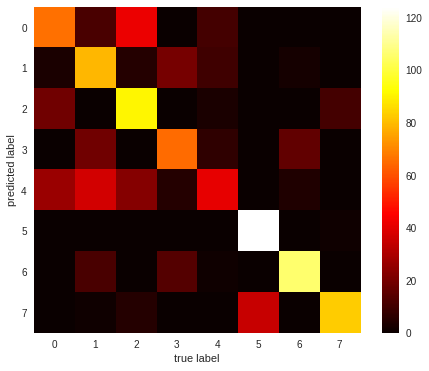

In [23]:
plt.figure(figsize=(8,6))
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Assignment
* In Step 3 design your own network
* Does the model perform better if you use all three RGB channels ?
* How does the performance change when using the La*b colorspace ?
